###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode
from micrograd.eval import evaluate, calc_accuracy, calc_sq_loss
from micrograd.visualize import draw_dot

%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

# Get MNIST dataset

In [3]:
from torchvision import datasets as dts

MNIST_DATASET = dts.MNIST(root = 'data', train = True, download=True)

X_train = MNIST_DATASET.data / 255.0 # * 2 - 1
X_train = X_train.reshape(X_train.shape[0], 784)

Y_train = MNIST_DATASET.targets

In [4]:
ALL_POSITIVE_CLASSES = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

enc, dec = oh_encode(ALL_POSITIVE_CLASSES)
enc(ALL_POSITIVE_CLASSES)

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [5]:
import torch


def append_noise(X, noise_size, min=-1.0, max=1.0):
    noise_shape = torch.Size([noise_size]) + X.shape[1:]
    noise_tensor = torch.empty(noise_shape).uniform_(min, max)
    return torch.concat([X, noise_tensor])


def append_void(X, void_size, void=-1.0):
    void_shape = torch.Size([void_size]) + X.shape[1:]
    void_tensor = torch.empty(void_shape).fill_(void)
    return torch.concat([X, void_tensor])


def get_batch(X, Y, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=-1):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y = X[ri], Y[ri]

    if noise_ratio > 0.0:
        noise_size = round(batch_size * noise_ratio)
        X = append_noise(X, noise_size)
        Y = torch.concat([Y, torch.tensor([void_class] * noise_size)])

    if void_ratio > 0.0:
        void_size = round(batch_size * void_ratio)
        X = append_void(X, void_size, void=np.random.uniform(0, 1))
        Y = torch.concat([Y, torch.tensor([void_class] * void_size)])

    return X, Y


def batch2vals(batch):
    return tuple(map(arr2vals, batch))


# save/load

In [6]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='sbin') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [7]:
import matplotlib.pyplot as plt


def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]


def select_batch(X, Y, selector, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=torch.nan):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], Y[idx], batch_size, noise_ratio, void_ratio, void_class)


def draw_neuron(model, neuron, layer=0):
    w = np.array([p.data for p in model.layers[layer].neurons[neuron].parameters()][:-1])
    w = w.reshape([-1, w.shape[0]])
    plt.imshow(w)


def one_neuron_histo(neuron, bins=100):
    array = np.array([p.data for p in neuron.parameters()])
    plt.hist(array, bins=bins, edgecolor='black')

    plt.title('Гистограмма нейрона')
    plt.xlabel('Вес')
    plt.ylabel('Частота')

    plt.show()


def draw_all_neurons(neurons, key=lambda p: p.data,):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([key(p) for p in neuron.parameters()][:28**2])
        array = array.reshape([-1, array.shape[0]])
        axe.imshow(array.reshape([28, 28]))
    fig.suptitle("Нейроны")


def all_neurons_histo(neurons, key=lambda p: p.data, bins=100):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([key(p) for p in neuron.parameters()])
        axe.hist(array, bins=bins, edgecolor='black')

    fig.suptitle('Гистограмма нейронов')
    fig.supxlabel('Вес')
    fig.supylabel('Частота')

    plt.show()

In [8]:
import functools

SELECTED_CLASSES = [0, 1]
OH_ENC, OH_DEC = oh_encode(SELECTED_CLASSES)

NOISE_RATIO = 0.0
VOID_RATIO = 0.0
ITERATIONS = 1
BATCH_SIZE = 100
BATCH = select_batch(X_train, Y_train, SELECTED_CLASSES, BATCH_SIZE, noise_ratio=NOISE_RATIO, void_ratio=VOID_RATIO)
X_b, Y_b = BATCH

X = arr2vals(X_b, 'input')
Y_oh = arr2vals(OH_ENC(Y_b), 'target')

# learning rate is inversely proportional to the samples number due to the nature of the loss function
# the loss function sums up all scores so the resulting gradient is the sum of all sample gradients
# that is why
LEARNING_RATE = 1.0 / len(X)
ESAT = 1e-9

MODEL = MLP(
    [
        Layer([784, len(SELECTED_CLASSES)], 'line', _lid=0, init=lambda: 0.0, _lr=LEARNING_RATE),
        # Layer([784, len(SELECTED_CLASSES)], 'sbin', _lid=0, init=lambda: 0.0, _lr=LEARNING_RATE)
    ],
    train=True
)

LEARNER = MODEL.make_learner(X, get_loss=functools.partial(calc_sq_loss, targets=Y_oh), ESAT=ESAT)

debug: minmax = (0.0, 0.0), space = 0.0
debug: minmax = (0.0, 0.0), space = 0.0


0 loss: 200.0
debug: minmax = (-9.99438007032767, 37.207070807511066), space = 47.20145087783874
debug: minmax = (-37.207070807511066, 9.99438007032767), space = 47.20145087783874
final loss: 136.85813655382586
accuracy = 0.24:
[(Value(div : [-0.12339433416210008, 0.0, 1.0]), Value(div : [0.12339433416210008, 0.0, 1.0])), (Value(div : [-0.12833085928921772, 0.0, 1.0]), Value(div : [0.12833085928921772, 0.0, 1.0])), (Value(div : [0.49148563463569406, 0.0, 1.0]), Value(div : [-0.49148563463569406, 0.0, 1.0])), (Value(div : [0.6683963180316942, 0.0, 1.0]), Value(div : [-0.6683963180316942, 0.0, 1.0])), (Value(div : [-0.164660244229957, 0.0, 1.0]), Value(div : [0.164660244229957, 0.0, 1.0])), (Value(div : [0.17909969731088457, 0.0, 1.0]), Value(div : [-0.17909969731088457, 0.0, 1.0])), (Value(div : [-0.17143456882854355, 0.0, 1.0]), Value(div : [0.17143456882854355, 0.0, 1.0])), (Value(div : [-0.14053802466445847, 0.0, 1.0]), Value(div : [0.14053802466445847, 0.0, 1.0])), (Value(div : [0.5

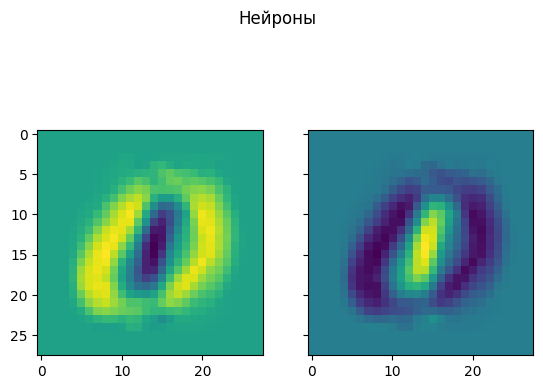

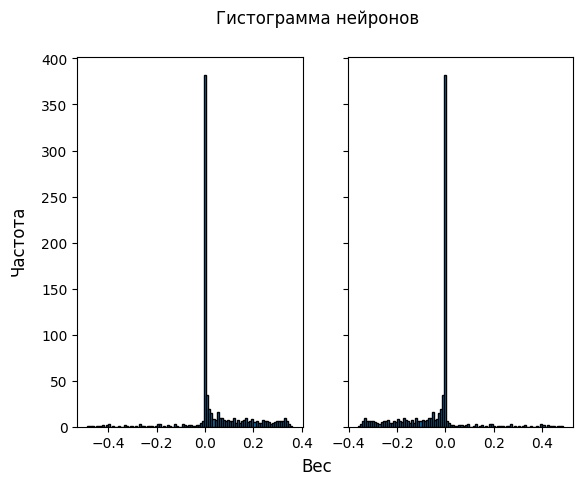

In [9]:
total_loss, scores = LEARNER(i=1, q=1.0)

acc = calc_accuracy(scores, Y_oh, OH_DEC)
print(f'accuracy = {acc}:\n{scores}')

draw_all_neurons(MODEL.layers[0].neurons)
all_neurons_histo(MODEL.layers[0].neurons)

# DEBUG

0 loss: 136.85813655382583
debug: minmax = (-10.413464944426122, 38.76723966993323), space = 49.18070461435936
debug: minmax = (-38.76723966993323, 10.413464944426122), space = 49.18070461435936
final loss: 136.85813655382583
accuracy = 0.24:
[(Value(div : [-0.12339433416210009, 0.0, 1.0]), Value(div : [0.12339433416210009, 0.0, 1.0])), (Value(div : [-0.1283308592892178, 0.0, 1.0]), Value(div : [0.1283308592892178, 0.0, 1.0])), (Value(div : [0.4914856346356936, 0.0, 1.0]), Value(div : [-0.4914856346356936, 0.0, 1.0])), (Value(div : [0.6683963180316945, 0.0, 1.0]), Value(div : [-0.6683963180316945, 0.0, 1.0])), (Value(div : [-0.16466024422995712, 0.0, 1.0]), Value(div : [0.16466024422995712, 0.0, 1.0])), (Value(div : [0.17909969731088457, 0.0, 1.0]), Value(div : [-0.17909969731088457, 0.0, 1.0])), (Value(div : [-0.17143456882854372, 0.0, 1.0]), Value(div : [0.17143456882854372, 0.0, 1.0])), (Value(div : [-0.1405380246644585, 0.0, 1.0]), Value(div : [0.1405380246644585, 0.0, 1.0])), (Val

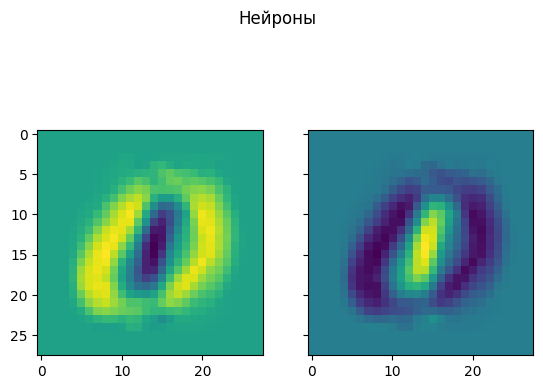

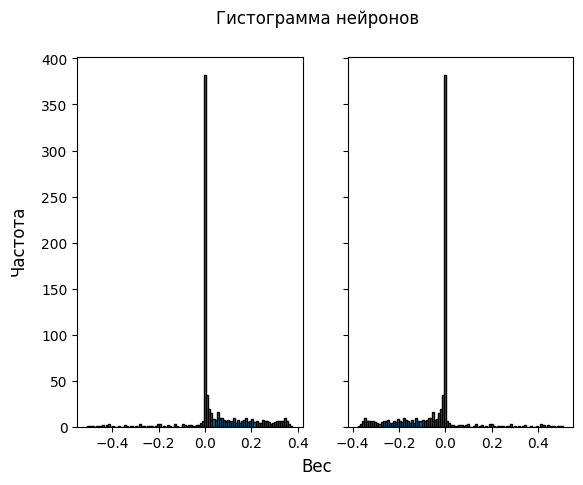

In [12]:
total_loss, scores = LEARNER(i=1, q=1.0)

acc = calc_accuracy(scores, Y_oh, OH_DEC)
print(f'accuracy = {acc}:\n{scores}')

draw_all_neurons(MODEL.layers[0].neurons)
all_neurons_histo(MODEL.layers[0].neurons)

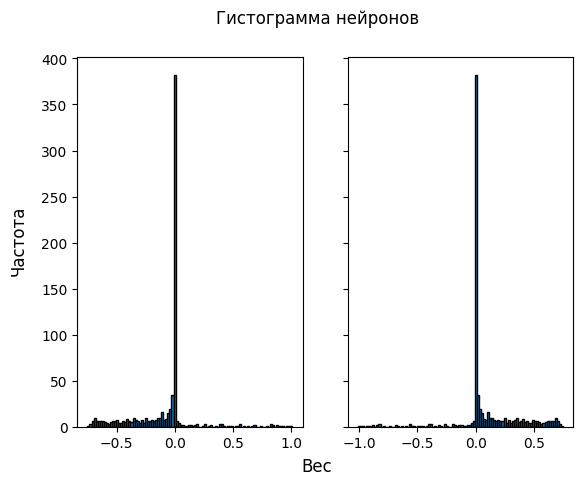

In [13]:
all_neurons_histo(MODEL.layers[0].neurons, key=lambda p: p.grad)

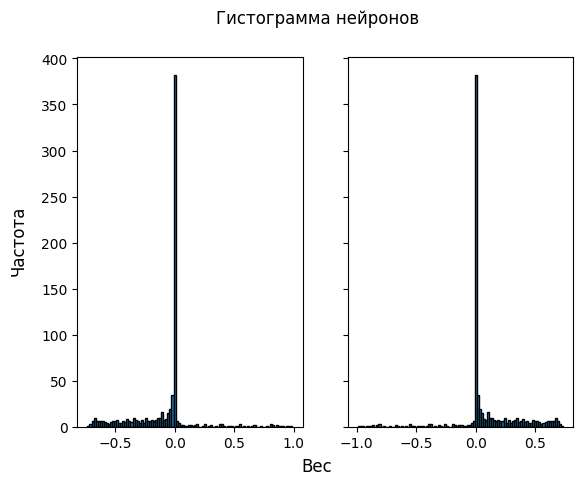

In [14]:
total_loss.backward()
all_neurons_histo(MODEL.layers[0].neurons, key=lambda p: p.grad)

In [15]:
import pandas as pd

data = [p.data for p in MODEL.layers[0].neurons[0].parameters()]
data.sort()

pd.DataFrame(data).describe()

,0
count,784.000000
mean,0.045625
std,0.136298
min,-0.506910
25%,0.000000
50%,0.000000
75%,0.094070
max,0.376403


In [16]:
data

[-0.506910158676171,
 -0.496572558924067,
 -0.4881962429193978,
 -0.464129655537911,
 -0.4553855983648178,
 -0.4484802447049448,
 -0.4430867145741667,
 -0.43957274859749773,
 -0.4211448529796681,
 -0.4194287273911706,
 -0.4184072271666489,
 -0.4175083049832947,
 -0.41121585169878766,
 -0.39213419619033785,
 -0.37133641482168567,
 -0.3431429567020695,
 -0.34028275125646806,
 -0.3339903010771605,
 -0.3172785276321089,
 -0.2990957922012999,
 -0.28606142484142494,
 -0.2846313210754712,
 -0.28287434045970317,
 -0.27560124425347393,
 -0.2677561107387047,
 -0.24642714629792759,
 -0.23547664516126784,
 -0.22926591533217835,
 -0.2136573628112015,
 -0.20503588472728076,
 -0.20262514035394888,
 -0.19939719554482066,
 -0.19555634861365176,
 -0.19008109603664594,
 -0.18950905331341442,
 -0.17627038801822995,
 -0.15947689739608603,
 -0.15718873008384307,
 -0.14521672641316952,
 -0.13161032051237853,
 -0.12744259233559727,
 -0.12715657161442886,
 -0.12168132125958148,
 -0.10027063904978334,
 -0.09716